# Визуализация и базовый EDA по Titanic

Сделал короткий EDA: посмотрел на пропуски, распределения и простые связи,
после чего собрал пайплайн обучения в `sklearn`.


## Импорт и загрузка данных

Подключаю основные библиотеки и загружаю датасет. Визуализации делаю через seaborn/matplotlib.


In [1]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8")


In [2]:
df = pd.read_csv(
    "data",
    sep=";",
)
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,Braund; Mr. Owen Harris,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,Cumings; Mrs. John Bradley (Florence Briggs Th...,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,Heikkinen; Miss. Laina,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,Futrelle; Mrs. Jacques Heath (Lily May Peel),female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,Allen; Mr. William Henry,male,35.0,0,0,373450,8.0500,NaN,S


## Быстрая проверка размера и пропусков

Сначала смотрю размер выборки и долю пропусков по признакам. Это помогает понять,
насколько активно придется делать иммитацию пропусков на этапе предобработки.


In [3]:
print(f"Data size: {df.shape}")
missing = df.isna().mean().sort_values(ascending=False)
missing.head(10)


Data size: (891, 12)


,0
Cabin,0.771044
Age,0.198653
Embarked,0.002245
PassengerId,0.000000
Name,0.000000
Pclass,0.000000
Survived,0.000000
Sex,0.000000
Parch,0.000000
SibSp,0.000000


## Визуализации

Ниже несколько базовых графиков: распределения ключевых числовых признаков
и простые зависимости целевой переменной от категорий.


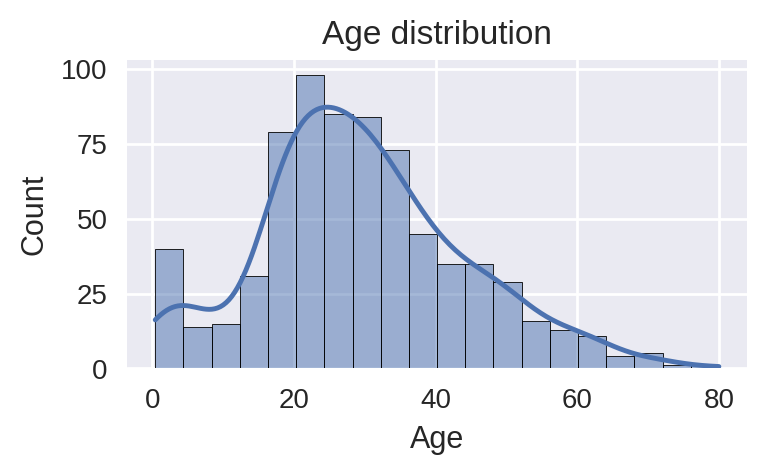

In [14]:
plt.figure(figsize=(4, 2), dpi=200)
sns.histplot(df, x="Age", kde=True)
plt.title("Age distribution")
plt.show()


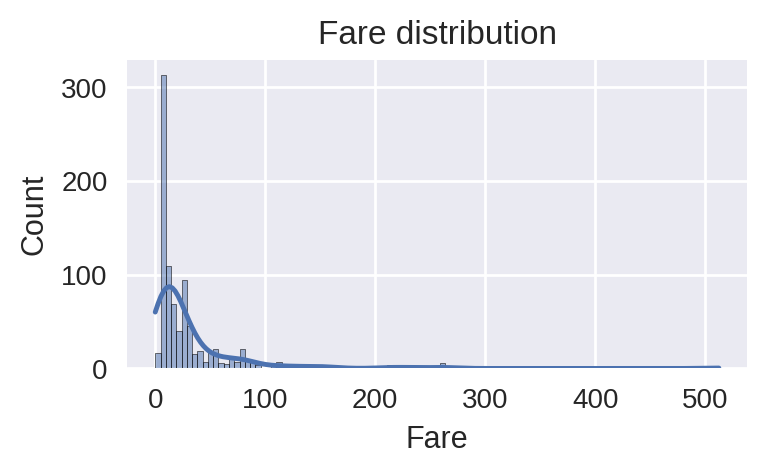

In [13]:
plt.figure(figsize=(4, 2), dpi=200)
sns.histplot(df, x="Fare", kde=True)
plt.title("Fare distribution")
plt.show()


Смотрю влияние пола на выживаемость — это один из сильных факторов в этом датасете.


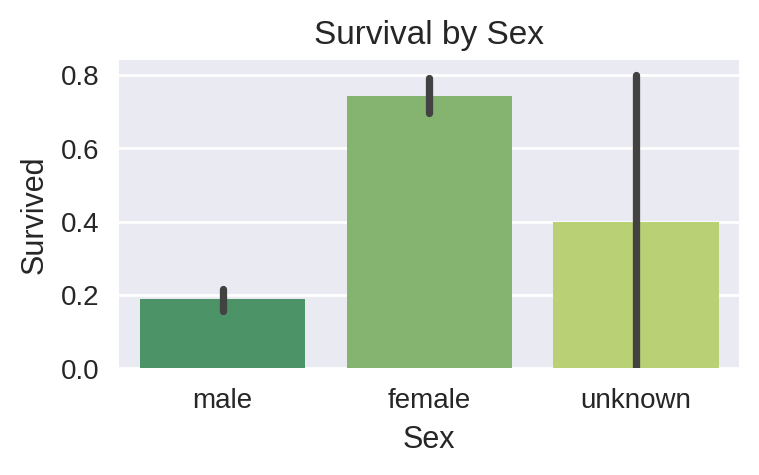

In [12]:
plt.figure(figsize=(4, 2), dpi=200)
sns.barplot(x="Sex", y="Survived", data=df, palette="summer")
plt.title("Survival by Sex")
plt.show()


Также проверяю связь с классом билета.


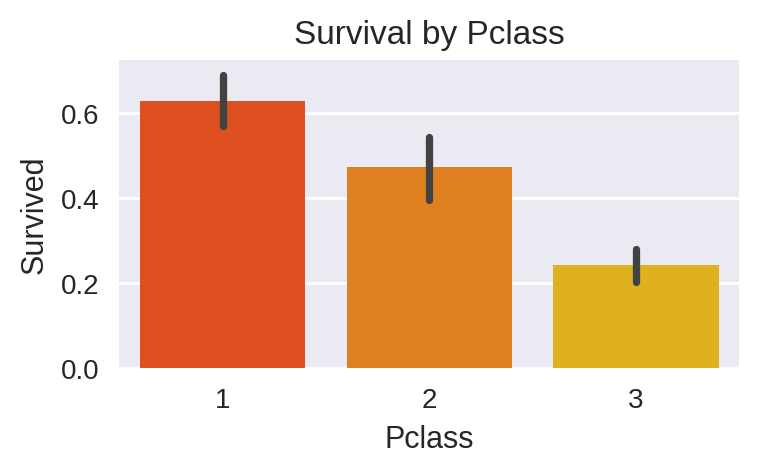

In [11]:
plt.figure(figsize=(4, 2), dpi=200)
sns.barplot(x="Pclass", y="Survived", data=df, palette="autumn")
plt.title("Survival by Pclass")
plt.show()


Ниже базовая scatter‑диаграмма, чтобы увидеть, как распределяются Age и Fare
с учётом выживаемости.


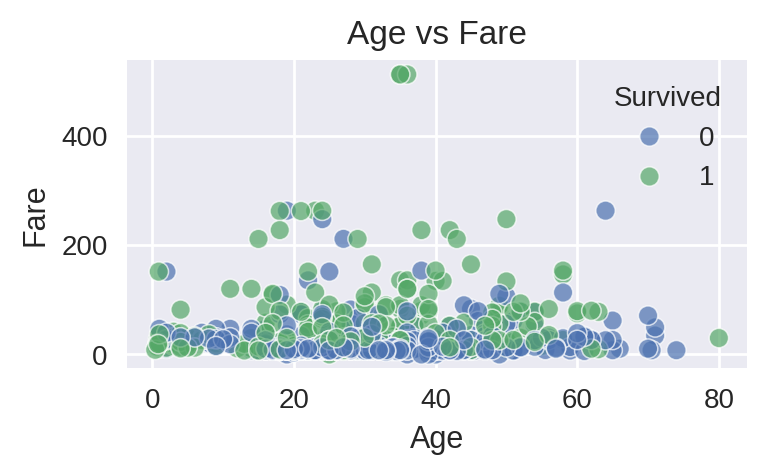

In [15]:
plt.figure(figsize=(4, 2), dpi=200)
sns.scatterplot(x="Age", y="Fare", hue="Survived", data=df, alpha=0.7)
plt.title("Age vs Fare")
plt.show()


### Корреляции числовых признаков

Считаю корреляцию числовых признаков и визуализирую heatmap,
чтобы быстро понять, что связано между собой и с целевой переменной.


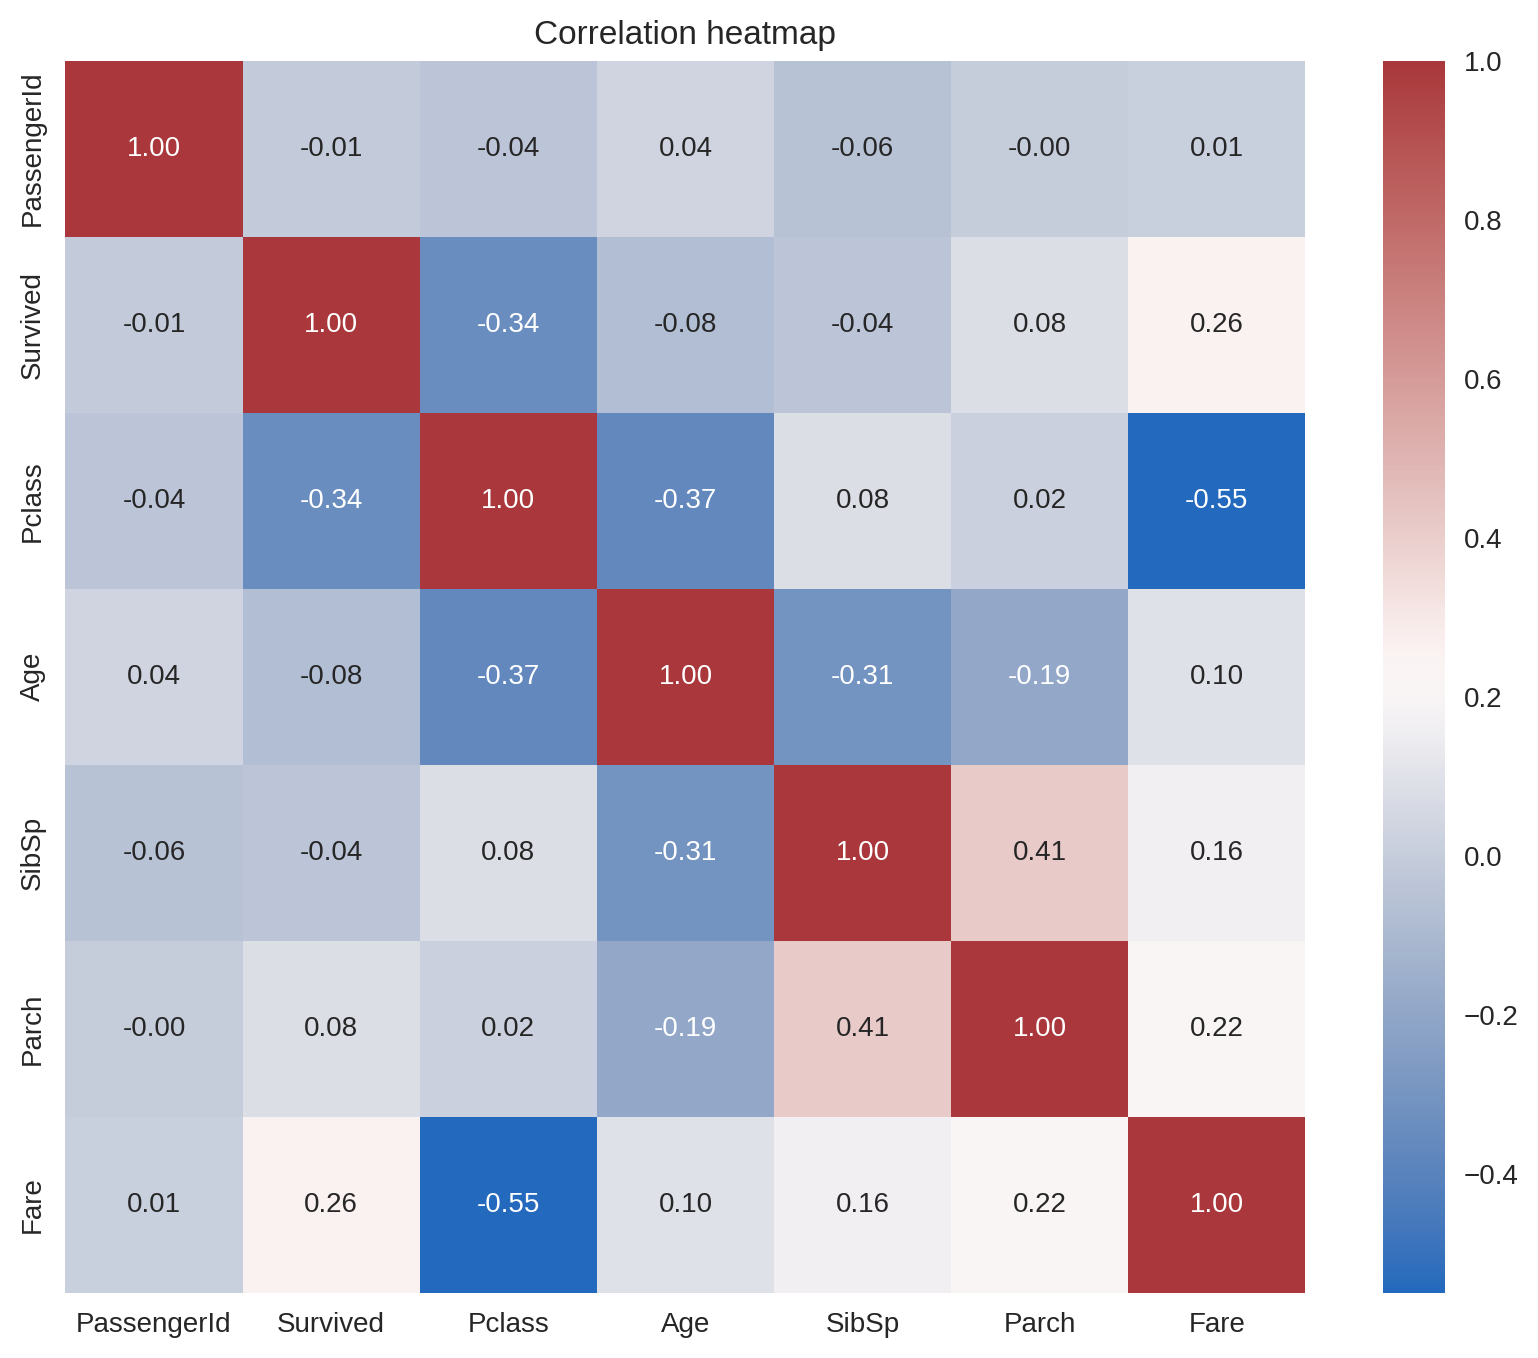

In [17]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(10, 8), dpi=200)
sns.heatmap(corr, cmap="vlag", annot=True, fmt=".2f")
plt.title("Correlation heatmap")
plt.show()


## Пайплайн обучения (sklearn)

Собрал пайплайн с минимальным feature engineering, обработкой пропусков
и кодированием категориальных признаков.


In [18]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder

df_model = df.copy()


### Feature engineering

Добавляю несколько простых признаков: длина имени, размер семьи,
флаг одиночного путешествия и обращение (Title) из имени.


In [19]:
def add_features(frame):
    frame = frame.copy()
    frame["NameLen"] = frame["Name"].str.len()
    frame["FamilySize"] = frame["Parch"] + frame["SibSp"] + 1
    frame["IsAlone"] = (frame["FamilySize"] == 1).astype(int)
    frame["Title"] = frame["Name"].str.extract(" ([A-Za-z]+)\\.", expand=False)
    frame["Title"] = frame["Title"].replace(
        ["Lady", "Countess", "Capt", "Col", "Don", "Dr", "Major", "Rev", "Sir", "Jonkheer", "Dona"],
        "Rare",
    )
    frame["Title"] = frame["Title"].replace({"Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs"})
    return frame


### Разделение на train/test

Делю данные на тренировочную и тестовую части, чтобы получить точную оценку
качества на отложенной выборке.


In [20]:
y = df_model["Survived"]
X = df_model.drop(columns=["Survived"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


### Предобработка и модель

Числовые признаки заполняю медианой, категориальные — наиболее частым значением
и кодирую one‑hot. В качестве базовой модели использую логистическую регрессию.


In [21]:
numeric_features = ["Age", "Fare", "SibSp", "Parch", "Pclass", "NameLen", "FamilySize", "IsAlone"]
categorical_features = ["Sex", "Embarked", "Title"]

numeric_pipe = Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))])
categorical_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, numeric_features),
        ("cat", categorical_pipe, categorical_features),
    ]
)

clf = Pipeline(
    steps=[
        ("features", FunctionTransformer(add_features)),
        ("preprocess", preprocess),
        ("model", LogisticRegression(max_iter=1000)),
    ]
)


### Обучение и оценка качества

Обучаю модель на train и оцениваю качество на test.
Accuracy — это доля правильных ответов: `(число верных предсказаний) / (общее число объектов)`.


In [22]:
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
acc = accuracy_score(y_test, pred)
print(f"Accuracy (holdout): {acc:.3f}")


Accuracy (holdout): 0.821


### K-Fold кросс‑валидация (5 фолдов)

Чтобы оценка была устойчивее, дополнительно считаю среднюю accuracy
по 5 фолдам.


In [23]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X, y, cv=cv, scoring="accuracy")
print(f"CV accuracy: {scores.mean():.3f} ± {scores.std():.3f}")


CV accuracy: 0.823 ± 0.010
